In [1]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import os
import numpy as np
import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

In [2]:
top_down_path = os.getcwd()
os.chdir("../Data")
data_path = os.getcwd()
os.chdir(top_down_path)

# Read data

In [3]:
# Read preprocessed
df = pd.read_csv(os.path.join(data_path, "preprocessed.csv"), index_col=0)
df.index = pd.to_datetime(df.index)

In [4]:
df[['rlm', 'slp']].mean() * 365 #/ df[['slp', 'rlm']].sum().sum()

rlm    586.975086
slp    408.364157
dtype: float64

In [5]:
df.head().transpose()

,2017-01-01,2017-01-02,2017-01-03,2017-01-04,2017-01-05
slp,2.302289,2.362777,2.284347,2.203892,2.509253
rlm,1.673442,2.056043,2.030095,2.108759,2.358004
industry,1.133007,1.31413,1.344038,1.399122,1.437929
gas_to_electricity_public,0.217912,0.367832,0.303461,0.311361,0.510752
electricity_from_gas,0.139161,0.234902,0.193794,0.198839,0.326173
gas_price [€/MWh],NaN,NaN,NaN,NaN,NaN
producing_sector,91.1,91.1,91.1,91.1,91.1
manufacturing_sector,94.1,94.1,94.1,94.1,94.1
hospitality_sector,82.6,82.6,82.6,82.6,82.6
retail_sector,96.1,96.1,96.1,96.1,96.1


# Prepare regression data

In [6]:
dfx = df.copy()
dfx = dfx.rename(columns={
    'aggregated': 'w2h',
    'gas_to_electricity_public': 'power',
    'producing_sector': 'prod',
    'manufacturing_sector': 'manu',
    'retail_sector': 'retail',
    'hospitality_sector': 'hosp',
    'gas_price [€/MWh]': 'prices',
    'temperature': 'temp',
    'temperature_inertia': 'temp_inertia',
})

dfx['log_slp'] = np.log(dfx['slp'])
dfx['log_rlm'] = np.log(dfx['rlm'])
dfx['log_power'] = np.log(dfx['power'])
dfx['log_industry'] = np.log(dfx['industry'])
dfx['power2'] = dfx['power'].apply(lambda x: x**2)

dfx = dfx[
    (dfx.holiday==0) & 
    (dfx.christmas_period==0) & 
    (dfx.bridgeday==0)
]

# Cut December 22-23
dfx = dfx[((dfx.index.month!=12)|(dfx.index.day<22))]

# Cut corona
# covid_beginning = "2020-02-01" --> lockdown started on 13 March 2020
#dfx = dfx[(dfx.index < '2020-03-01')|(dfx.index >= '2021-05-01')]
# invasion_date = "2022-02-24"


In [7]:
def model(dependent_variable, control_list):
    
    m = f'{dependent_variable} ~ 1 + time + C(month) + C(weekday) + ' + ' + '.join(control_list)
    print(m)
    return smf.ols(m, dfx.loc[fitting_start:]).fit(cov_type='HAC', cov_kwds={'maxlags':6})

In [8]:
def all_models(dummy_list, consumer='rlm', further_controls=False, econ=False):
    
    results = {}
    
    names = ['naive', 'temp',]
    if econ:
        names += ['temp+econ']
    if consumer == 'rlm':
        names += ['temp+econ']
    if consumer == 'power':
        names = ['naive']
    
    for name in names:
    
        control_list = [d for d in dummy_list]        
        if 'temp' in name:
            control_list += ['w2h','time*w2h']
        if 'econ' in name:
            control_list += ['manu'] if (consumer=='rlm' or consumer=='industry') else ['hosp','retail']
        if 'naive' in name:
            control_list = control_list
        results[name] = model(f'{"log_" if log else ""}{consumer}', control_list)

    return results

In [9]:
np.corrcoef(dfx['commercial'], dfx['residential']) #very strong correlation between commercial and residential

array([[1.        , 0.99673407],
       [0.99673407, 1.        ]])

In [10]:
np.corrcoef(dfx['manu'], dfx['prod']) #very strong correlation between manu and prod

array([[1.        , 0.97392426],
       [0.97392426, 1.        ]])

In [11]:
def extract_results(dummy_list, results):
    
    extracted_results = pd.concat(
        [results.params, results.bse], keys=['coef', 'se'], axis=1
    )
    
    extracted_results = extracted_results*100 if log else extracted_results
    extracted_results = extracted_results.loc[[d + '[T.True]' for d in dummy_list]]
    extracted_results.index = dummy_list
    extracted_results['low'] = extracted_results['coef'] - 2 * extracted_results['se']
    extracted_results['high'] = extracted_results['coef'] + 2 * extracted_results['se']
    
    return extracted_results

# One crisis dummy

In [12]:
title_conversion = {
        'slp':'Small consumers',
        'rlm':'Large consumers',
        'industry':'Industrial consumers',  
        'power':'Power sector'  
}

In [13]:
def plot_waterfall(ax, results, consumer='rlm', ylabel=''):

    colors = ['tab:blue', 'tab:orange', 'tab:purple', 'tab:green', 'tab:red']
    
    for i, (name, res) in enumerate(results.items()):
        
        # first bar
        if i==0:
            ax.bar(i, res['coef'], alpha=0.5, color=colors[i])
            ax.plot([i,i], [res['low'], res['high']], color=colors[i])
        
        # waterfall
        if i > 0:
            ax.bar(i, res['coef'] - previous_coef, bottom=previous_coef, alpha=0.5, color=colors[i])    
            ax.plot([i-1.4,i+0.4], [previous_coef, previous_coef], color='black', linewidth=0.7, linestyle='--')
            ax.plot([i-0.4,i+1.4], [res['coef'], res['coef']], color='black', linewidth=0.7, linestyle='--')
            
        previous_coef = res['coef']
    
    # last bar
    if consumer != "power":
        i += 1
        ax.bar(i, res['coef'], alpha=0.5, color=colors[-1])
        ax.plot([i,i], [res['low'], res['high']], color=colors[-1])

    ax.grid(axis='y')
    ax.axhline(0, color='black', linewidth=0.5)
    ax.set_ylabel(ylabel)
    ax.set_title(title_conversion[consumer])    
    if log:
        ax.set_ylim(-21, 7)
        
    labels = ['Overall\nchange', 'Temperature']
    if 'temp+econ' in results.keys():
        labels += ['Economic\nactivity']
    if consumer=='rlm': 
        labels += ['Power\nsector']
    if consumer=='power': 
        labels = ['Overall\nchange']
    ax.set_xticks(range(len(results)) if consumer == "power" else range(len(results)+1))
    ax.set_xticklabels(labels if consumer == "power" else (labels + ['Crisis\nresponse']))

In [14]:
def one_dummy(further_controls=False, econ=False):
    
    dummy_list=['crisis']
    dfx['crisis'] = dfx.index.map(lambda x: x >= crisis_start)

    results = {
        consumer: all_models(dummy_list, consumer, further_controls=further_controls, econ=econ) 
        for consumer in ['slp', 'industry', 'power']

    }
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4.5), sharey='row', gridspec_kw={'width_ratios': [1,1,0.4]})

    res = {m: extract_results(dummy_list, value) for m, value in results['slp'].items()}
    ax1 = plot_waterfall(ax1, res, 'slp', 'Estimated change in demand ' + ('(%)' if log else '(TWh/d)'))

    res = {m: extract_results(dummy_list, value) for m, value in results['industry'].items()}
    ax2 = plot_waterfall(ax2, res, 'industry')
    
    res = {m: extract_results(dummy_list, value) for m, value in results['power'].items()}
    ax3 = plot_waterfall(ax3, res, 'power')

    plt.tight_layout()
    
    return results

## Main Specification

slp ~ 1 + time + C(month) + C(weekday) + crisis
slp ~ 1 + time + C(month) + C(weekday) + crisis + w2h + time*w2h
slp ~ 1 + time + C(month) + C(weekday) + crisis + w2h + time*w2h + hosp + retail
industry ~ 1 + time + C(month) + C(weekday) + crisis
industry ~ 1 + time + C(month) + C(weekday) + crisis + w2h + time*w2h
industry ~ 1 + time + C(month) + C(weekday) + crisis + w2h + time*w2h + manu
power ~ 1 + time + C(month) + C(weekday) + crisis


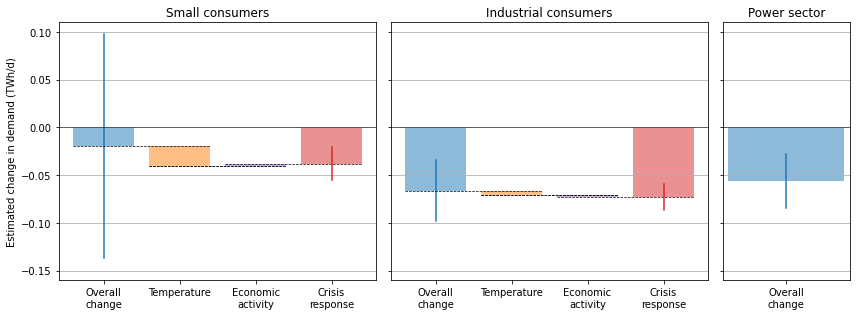

In [15]:
log=False
fitting_start = "2017-01-01"
crisis_start = "2021-08-01"
results = one_dummy(econ=True)
plt.ylim(-.16, .11)
plt.savefig(f'one_dummy.png', dpi=300)

In [16]:
results['slp']['temp+econ'].summary()
#results['power']['naive'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    slp   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     9894.
Date:                Wed, 20 Jul 2022   Prob (F-statistic):               0.00
Time:                        18:09:34   Log-Likelihood:                 2953.4
No. Observations:                1788   AIC:                            -5859.
Df Residuals:                    1764   BIC:                            -5727.
Df Model:                          23                                         
Covariance Type:                  HAC                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.2608      0.075      3.486      0.000       0.114       0.407
C(month)[T.2]               0.0019      0.010      0.193      0.847      -0.018       0.022
C(month)[T.3]              -0.0611      0.015     -4.081      0.000      -0.090      -0.032
C(month)[T.4]              -0.1466      0.014    -10.380      0.000      -0.174      -0.119
C(month)[T.5]              -0.1798      0.017    -10.648      0.000      -0.213      -0.147
C(month)[T.6]              -0.1790      0.018    -10.098      0.000      -0.214      -0.144
C(month)[T.7]              -0.1831      0.018    -10.120      0.000      -0.219      -0.148
C(month)[T.8]              -0.1843      0.017    -10.857      0.000      -0.218      -0.151
C(month)[T.9]              -0.1849      0.017    -10.765      0.000      -0.219      -0.151
C(month)[T.10]             -0.1464      0.017     -8.579      0.000      -0.180      -0.113
C(month)[T.11]             -0.0829      0.019     -4.396      0.000      -0.120      -0.046
C(month)[T.12]             -0.0062      0.023     -0.265      0.791      -0.052       0.039
C(weekday)[T.Monday]       -0.0058      0.004     -1.629      0.103      -0.013       0.001
C(weekday)[T.Saturday]     -0.0049      0.002     -1.961      0.050      -0.010   -1.56e-06
C(weekday)[T.Sunday]       -0.0019      0.003     -0.565      0.572      -0.008       0.005
C(weekday)[T.Thursday]     -0.0012      0.003     -0.450      0.653      -0.006       0.004
C(weekday)[T.Tuesday]      -0.0043      0.004     -1.164      0.244      -0.012       0.003
C(weekday)[T.Wednesday]    -0.0034      0.003     -1.039      0.299      -0.010       0.003
crisis[T.True]             -0.0381      0.009     -4.428      0.000      -0.055      -0.021
time                     1.849e-05   1.05e-05      1.764      0.078   -2.06e-06     3.9e-05
w2h                         0.9535      0.008    119.040      0.000       0.938       0.969
time:w2h                 3.165e-05   5.45e-06      5.811      0.000     2.1e-05    4.23e-05
hosp                       -0.0001      0.000     -0.866      0.386      -0.000       0.000
retail                     -0.0006      0.001     -0.842      0.400      -0.002       0.001
==============================================================================
Omnibus:                       42.080   Durbin-Watson:                   0.572
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               90.053
Skew:                           0.064   Prob(JB):                     2.79e-20
Kurtosis:                       4.092   Cond. No.                     6.41e+04
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 6 lags and without small sample cor

In [17]:
# year-on-year
for con, mod  in [('industry','temp+econ'),('slp','temp+econ'),('power','naive')]:
    
    crisis_coefficient = -results[con][mod].params["crisis[T.True]"]
    ref = dfx[(dfx.index >= '2020-08-01') & (dfx.index < '2021-05-01')][con].mean()  #, (338+58)/(338+141+58))
    print(
          title_conversion[con] + ": " + str(round(crisis_coefficient,4)) + " TWh/d " + "\n" +"which is " + str(round(100*crisis_coefficient/ ref)) +" % of "+ str(round(ref,4)) + " TWh/d avg. demand during months 8-3 before crisis"+ "\n" 
         )

Industrial consumers: 0.0725 TWh/d 
which is 7 % of 1.0944 TWh/d avg. demand during months 8-3 before crisis

Small consumers: 0.0381 TWh/d 
which is 3 % of 1.386 TWh/d avg. demand during months 8-3 before crisis

Power sector: 0.0559 TWh/d 
which is 14 % of 0.3968 TWh/d avg. demand during months 8-3 before crisis



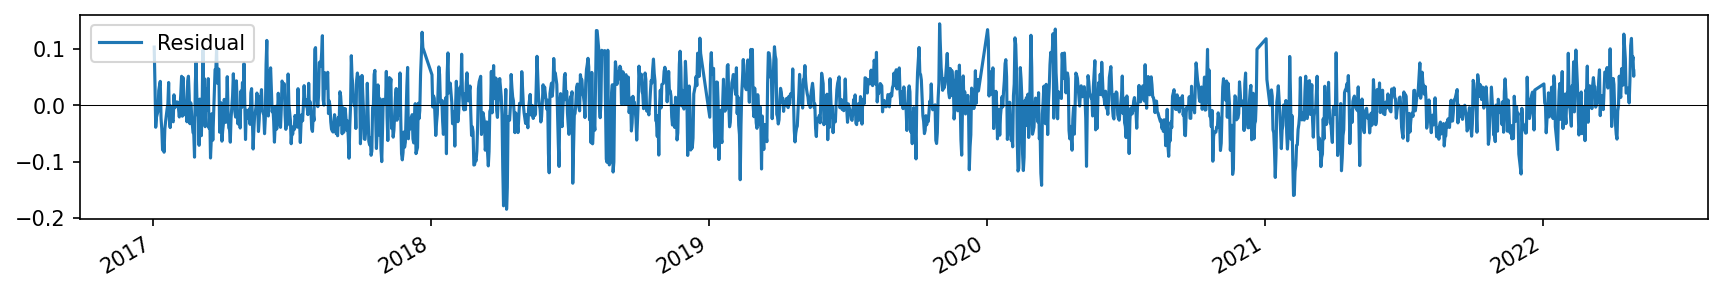

In [18]:
resid = results['industry']['temp+econ'].fittedvalues - dfx['industry'] 

plt.figure(figsize=(14, 2), dpi=150)
#results['rlm']['temp+power+econ'].fittedvalues.plot(label='Fitted')
#dfx['rlm'].plot(label='Observed')
resid.plot(label='Residual')
plt.axhline(0, color='black', linewidth=0.5)
plt.legend(loc='upper left')

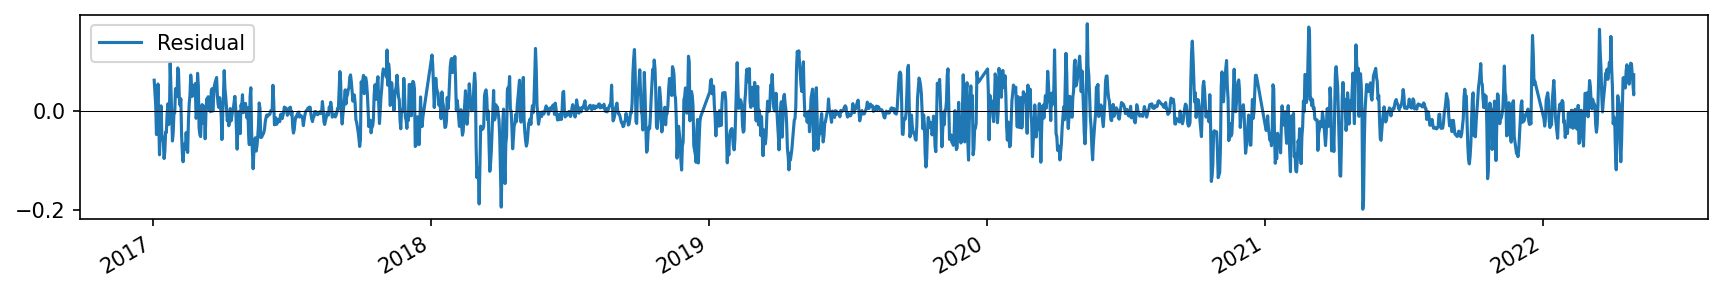

In [19]:
resid = results['slp']['temp+econ'].fittedvalues - dfx['slp'] 

plt.figure(figsize=(14, 2), dpi=150)
#results['slp']['temp+econ'].fittedvalues.plot(label='Fitted')
#dfx['slp'].plot(label='Observed')
resid.plot(label='Residual')
plt.axhline(0, color='black', linewidth=0.5)
plt.legend()

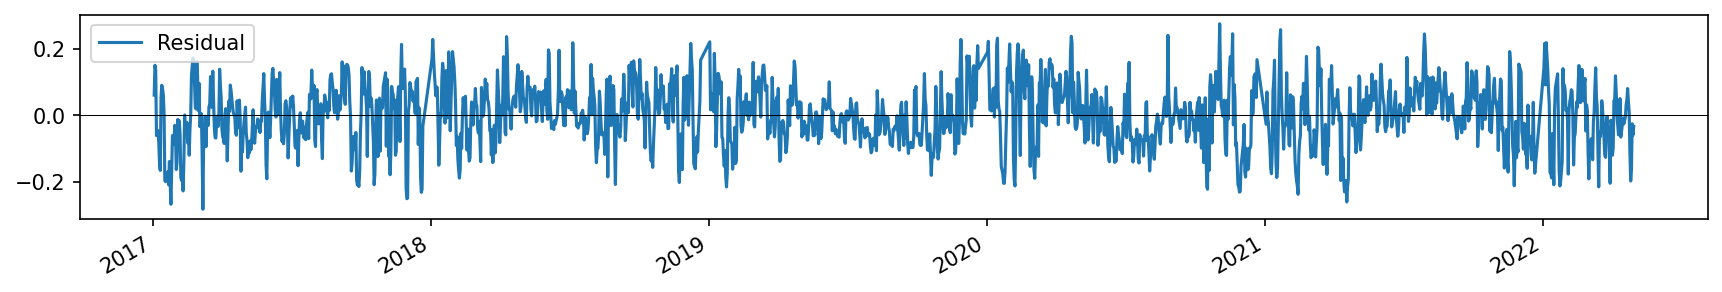

In [20]:
resid = results['power']['naive'].fittedvalues - dfx['power'] 

plt.figure(figsize=(14, 2), dpi=150)

resid.plot(label='Residual')
plt.axhline(0, color='black', linewidth=0.5)
plt.legend()

## Sensitivities

Crisis start: 1-2 month later crisis start does not change a lot, but including June-July significantly reduces average response of small & industrial consumers

slp ~ 1 + time + C(month) + C(weekday) + crisis
slp ~ 1 + time + C(month) + C(weekday) + crisis + w2h + time*w2h
slp ~ 1 + time + C(month) + C(weekday) + crisis + w2h + time*w2h + hosp + retail
industry ~ 1 + time + C(month) + C(weekday) + crisis
industry ~ 1 + time + C(month) + C(weekday) + crisis + w2h + time*w2h
industry ~ 1 + time + C(month) + C(weekday) + crisis + w2h + time*w2h + manu
power ~ 1 + time + C(month) + C(weekday) + crisis


(-0.21, 0.11)

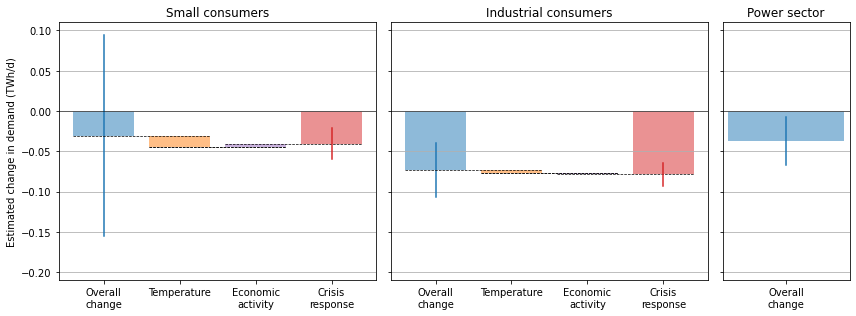

In [21]:
log=False
fitting_start = "2017-01-01"
crisis_start = "2021-09-01" #default: 2021-08-01
results = one_dummy(econ=True)
plt.ylim(-.21, .11)

Fitting period: Quite sensitive to change in fitting period, crisis response of industrial consumers increases with reduced fitting period while small consumers' response is rather stable

slp ~ 1 + time + C(month) + C(weekday) + crisis
slp ~ 1 + time + C(month) + C(weekday) + crisis + w2h + time*w2h
slp ~ 1 + time + C(month) + C(weekday) + crisis + w2h + time*w2h + hosp + retail
industry ~ 1 + time + C(month) + C(weekday) + crisis
industry ~ 1 + time + C(month) + C(weekday) + crisis + w2h + time*w2h
industry ~ 1 + time + C(month) + C(weekday) + crisis + w2h + time*w2h + manu
power ~ 1 + time + C(month) + C(weekday) + crisis


(-0.21, 0.11)

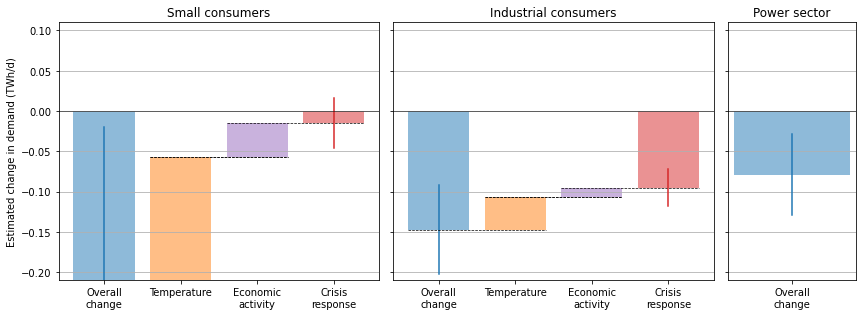

In [22]:
log=False
fitting_start = "2020-01-01" #default: 2017-01-01
crisis_start = "2021-08-01" 
results = one_dummy(econ=True)
plt.ylim(-.21, .11)

Add/remove control variables: Omitting economic activity does not change a lot

slp ~ 1 + time + C(month) + C(weekday) + crisis
slp ~ 1 + time + C(month) + C(weekday) + crisis + w2h + time*w2h
industry ~ 1 + time + C(month) + C(weekday) + crisis
industry ~ 1 + time + C(month) + C(weekday) + crisis + w2h + time*w2h
power ~ 1 + time + C(month) + C(weekday) + crisis


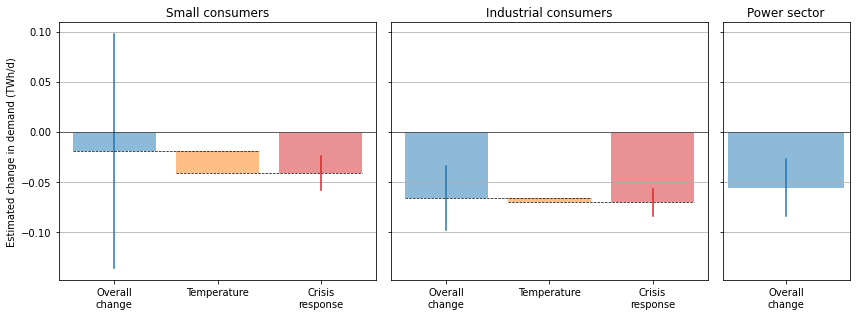

In [23]:
log=False
fitting_start = "2017-01-01"
crisis_start = "2021-08-01"
results = one_dummy(econ=False)

# Quarterly dummies (not currently used)

In [24]:
mode = 'quarterly'
crisis_start = "2021-09-01"
dummy_list = []
for date in pd.date_range(crisis_start, '2022-04', freq='3m'):
    dummy_name = f'd{date.year}_{date.quarter}'
    dfx[dummy_name] = dfx.index.map( 
        lambda x: (x.year==date.year) & (x.quarter==date.quarter)
    ).values
    dummy_list.append(dummy_name)

# Monthly dummies

In [25]:
mode = 'monthly'
crisis_start = "2021-05-01"
dummy_list = []
for date in pd.date_range(crisis_start, '2022-05', freq='1m'):
    dummy_name = f'd{date.year}_{date.month}'
    dfx[dummy_name] = dfx.index.map(   
        lambda x: (x.year==date.year) & (x.month==date.month)
    ).values
    dummy_list.append(dummy_name)

In [26]:
def plot_monthly(ax, results, consumer='industry', ylabel='Crisis response (TWh/d)', names=None):

    colors = {
        'naive': 'tab:blue',
        'temp+econ': ('tab:orange' if consumer=='industry' else 'tab:red'),
        'power': 'tab:green'
    }
    extracted_results = {m: extract_results(dummy_list, value) for m, value in results[consumer].items()}
    
    if names==None:
        names = extracted_results.keys()
    
    for i, name in enumerate(names):
        
        res = extracted_results[name]
        
        idx = [j-0.15*(len(names)-1)+0.6/len(names)*i for j in range(len(res))]
        ax.bar(idx, res['coef'], width=0.6/len(names),alpha=0.5, label=name, color=colors[name])
        for j, d in enumerate(dummy_list):
            ax.plot([idx[j], idx[j]], [res.loc[d, 'low'], res.loc[d, 'high']], 
                     color=colors[name])
    ax.grid(axis='y')
    ax.axhline(0, color='black', linewidth=0.5)
    ax.set_ylabel(ylabel)
    ax.set_ylim(-0.21, 0.1)
    title_conversion = {
        'slp':'Small consumers',
        'rlm':'Large consumers',
        'industry':'Industrial consumers',
        'power': "Power sector"
    }
    ax.set_title(title_conversion[consumer])
   
    ax.set_xticks(
        range(len(res)), 
    #    [f'{date.month_name()[:3]}'+(f'\n{date.year}' if ((date.month==1) | (i==0)) else '')
    #     for i, date in enumerate(pd.date_range(crisis_start, '2022-05', freq='1m'))]
    )
    ax.set_xticklabels(
        [f'{date.month_name()[:3]}'+(f'\n{date.year}' if ((date.month==1) | (i==0)) else '')
         for i, date in enumerate(pd.date_range(crisis_start, '2022-05', freq='1m'))]
    )
    
    ax.axvline(7.5, color='black', linewidth=0.5)

In [27]:
log=False
results = {consumer: all_models(dummy_list, consumer, econ=True) for consumer in ['slp', 'industry', 'power']}

slp ~ 1 + time + C(month) + C(weekday) + d2021_5 + d2021_6 + d2021_7 + d2021_8 + d2021_9 + d2021_10 + d2021_11 + d2021_12 + d2022_1 + d2022_2 + d2022_3 + d2022_4
slp ~ 1 + time + C(month) + C(weekday) + d2021_5 + d2021_6 + d2021_7 + d2021_8 + d2021_9 + d2021_10 + d2021_11 + d2021_12 + d2022_1 + d2022_2 + d2022_3 + d2022_4 + w2h + time*w2h
slp ~ 1 + time + C(month) + C(weekday) + d2021_5 + d2021_6 + d2021_7 + d2021_8 + d2021_9 + d2021_10 + d2021_11 + d2021_12 + d2022_1 + d2022_2 + d2022_3 + d2022_4 + w2h + time*w2h + hosp + retail
industry ~ 1 + time + C(month) + C(weekday) + d2021_5 + d2021_6 + d2021_7 + d2021_8 + d2021_9 + d2021_10 + d2021_11 + d2021_12 + d2022_1 + d2022_2 + d2022_3 + d2022_4
industry ~ 1 + time + C(month) + C(weekday) + d2021_5 + d2021_6 + d2021_7 + d2021_8 + d2021_9 + d2021_10 + d2021_11 + d2021_12 + d2022_1 + d2022_2 + d2022_3 + d2022_4 + w2h + time*w2h
industry ~ 1 + time + C(month) + C(weekday) + d2021_5 + d2021_6 + d2021_7 + d2021_8 + d2021_9 + d2021_10 + d2021_

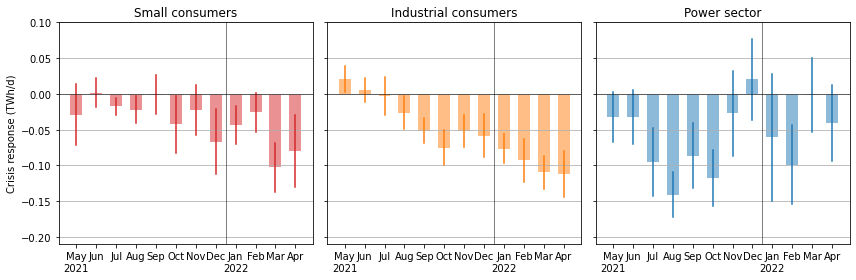

In [28]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4), sharey='row', gridspec_kw={'width_ratios': [1,1,1]})

plot_monthly(ax1, results, 'slp', names=['temp+econ'])
#ax1.text(10.5, 0.02, 'Invasion\nof Ukraine', horizontalalignment='center')

plot_monthly(ax2, results, names=['temp+econ'], ylabel='')
#ax2.text(4.5, 0.02, 'TTF prices\nall-time-high', horizontalalignment='center')

plot_monthly(ax3, results, "power", names=['naive'], ylabel='')
#ax2.text(4.5, 0.02, 'TTF prices\nall-time-high', horizontalalignment='center')

plt.tight_layout()
plt.savefig('months.png')

In [29]:
#results['industry']['temp+econ'].summary()
#results['power']['naive'].summary()

In [30]:
#May 2021 reduction

for con, mod  in [('industry','temp+econ'),('slp','temp+econ')]:
    
    crisis_coefficient = -results[con][mod].params["d2021_5[T.True]"]
    ref = dfx[(dfx.index.year < 2021) & (dfx.index.month.isin([5]))][con].mean()
    print(
          title_conversion[con] + ": " + str(round(-crisis_coefficient,4)) + " TWh/d in May 2021 " + "\n" +"which is " + str(round(100*crisis_coefficient/ ref)) +" % of "+ str(round(ref,4)) + " TWh/d avg. May demand "+ "\n" 
         )

Industrial consumers: 0.0211 TWh/d in May 2021 
which is -2 % of 0.8475 TWh/d avg. May demand 

Small consumers: -0.0289 TWh/d in May 2021 
which is 5 % of 0.6072 TWh/d avg. May demand 



In [31]:
#June 2021 reduction

for con, mod  in [('industry','temp+econ'),('slp','temp+econ')]:
    
    crisis_coefficient = -results[con][mod].params["d2021_6[T.True]"]
    ref = dfx[(dfx.index.year < 2021) & (dfx.index.month.isin([6]))][con].mean()
    print(
          title_conversion[con] + ": " + str(round(-crisis_coefficient,4)) + " TWh/d in June 2021 " + "\n" +"which is " + str(round(100*crisis_coefficient/ ref)) +" % of "+ str(round(ref,4)) + " TWh/d avg. June demand "+ "\n" 
         )

Industrial consumers: 0.0055 TWh/d in June 2021 
which is -1 % of 0.7743 TWh/d avg. June demand 

Small consumers: 0.002 TWh/d in June 2021 
which is -1 % of 0.2729 TWh/d avg. June demand 



In [32]:
#July 2021 reduction

for con, mod  in [('industry','temp+econ'),('slp','temp+econ')]:
    
    crisis_coefficient = -results[con][mod].params["d2021_7[T.True]"]
    ref = dfx[(dfx.index.year < 2021) & (dfx.index.month.isin([7]))][con].mean()
    print(
          title_conversion[con] + ": " + str(round(-crisis_coefficient,4)) + " TWh/d in July 2021 " + "\n" +"which is " + str(round(100*crisis_coefficient/ ref)) +" % of "+ str(round(ref,4)) + " TWh/d avg. July demand "+ "\n" 
         )

Industrial consumers: -0.0025 TWh/d in July 2021 
which is 0 % of 0.7633 TWh/d avg. July demand 

Small consumers: -0.0173 TWh/d in July 2021 
which is 7 % of 0.248 TWh/d avg. July demand 



In [33]:
#August 2021 reduction

for con, mod  in [('industry','temp+econ'),('slp','temp+econ')]:
    
    crisis_coefficient = -results[con][mod].params["d2021_8[T.True]"]
    ref = dfx[(dfx.index.year < 2021) & (dfx.index.month.isin([8]))][con].mean()
    print(
          title_conversion[con] + ": " + str(round(-crisis_coefficient,4)) + " TWh/d in August 2021 " + "\n" +"which is " + str(round(100*crisis_coefficient/ ref)) +" % of "+ str(round(ref,4)) + " TWh/d avg. August demand "+ "\n" 
         )

Industrial consumers: -0.0262 TWh/d in August 2021 
which is 4 % of 0.7489 TWh/d avg. August demand 

Small consumers: -0.0219 TWh/d in August 2021 
which is 9 % of 0.2314 TWh/d avg. August demand 



In [34]:
#September 2021 reduction

for con, mod  in [('industry','temp+econ'),('slp','temp+econ')]:
    
    crisis_coefficient = -results[con][mod].params["d2021_9[T.True]"]
#    ref = dfx[(dfx.index.month.isin([9]))][con].mean()
    ref = dfx[(dfx.index.year < 2021) & (dfx.index.month.isin([9]))][con].mean()
    print(
          title_conversion[con] + ": " + str(round(-crisis_coefficient,4)) + " TWh/d in September 2021 " + "\n" +"which is " + str(round(100*crisis_coefficient/ ref)) +" % of "+ str(round(ref,4)) + " TWh/d avg. September demand "+ "\n" 
         )

Industrial consumers: -0.0511 TWh/d in September 2021 
which is 6 % of 0.8437 TWh/d avg. September demand 

Small consumers: -0.0008 TWh/d in September 2021 
which is 0 % of 0.46 TWh/d avg. September demand 



In [35]:
#October 2021 reduction

for con, mod  in [('industry','temp+econ'),('slp','temp+econ')]:
    
    crisis_coefficient = -results[con][mod].params["d2021_10[T.True]"]
    ref = dfx[(dfx.index.year < 2021) & (dfx.index.month.isin([10]))][con].mean()
    print(
          title_conversion[con] + ": " + str(round(-crisis_coefficient,4)) + " TWh/d in October 2021 " + "\n" +"which is " + str(round(100*crisis_coefficient/ ref)) +" % of "+ str(round(ref,4)) + " TWh/d avg. October demand "+ "\n" 
         )

Industrial consumers: -0.0749 TWh/d in October 2021 
which is 8 % of 0.9734 TWh/d avg. October demand 

Small consumers: -0.0426 TWh/d in October 2021 
which is 5 % of 0.8256 TWh/d avg. October demand 



In [36]:
#November 2021 reduction

for con, mod  in [('industry','temp+econ'),('slp','temp+econ')]:
    
    crisis_coefficient = -results[con][mod].params["d2021_11[T.True]"]
    ref = dfx[(dfx.index.year < 2021) & (dfx.index.month.isin([11]))][con].mean()
    print(
          title_conversion[con] + ": " + str(round(-crisis_coefficient,4)) + " TWh/d in November 2021 " + "\n" +"which is " + str(round(100*crisis_coefficient/ ref)) +" % of "+ str(round(ref,4)) + " TWh/d avg. November demand "+ "\n" 
         )

Industrial consumers: -0.0523 TWh/d in November 2021 
which is 5 % of 1.1541 TWh/d avg. November demand 

Small consumers: -0.0226 TWh/d in November 2021 
which is 1 % of 1.5509 TWh/d avg. November demand 



In [37]:
#December 2021 reduction

for con, mod  in [('industry','temp+econ'),('slp','temp+econ')]:
    
    crisis_coefficient = -results[con][mod].params["d2021_12[T.True]"]
    ref = dfx[(dfx.index.year < 2021) & (dfx.index.month.isin([12]))][con].mean()
    print(
          title_conversion[con] + ": " + str(round(-crisis_coefficient,4)) + " TWh/d in December 2021 " + "\n" +"which is " + str(round(100*crisis_coefficient/ ref)) +" % of "+ str(round(ref,4)) + " TWh/d avg. December demand "+ "\n" 
         )

Industrial consumers: -0.0582 TWh/d in December 2021 
which is 5 % of 1.2281 TWh/d avg. December demand 

Small consumers: -0.0668 TWh/d in December 2021 
which is 3 % of 1.9187 TWh/d avg. December demand 



In [38]:
#January 2022 reduction

for con, mod  in [('industry','temp+econ'),('slp','temp+econ')]:
    
    crisis_coefficient = -results[con][mod].params["d2022_1[T.True]"]
    ref = dfx[(dfx.index.year < 2022) & (dfx.index.month.isin([1]))][con].mean()
    print(
          title_conversion[con] + ": " + str(round(-crisis_coefficient,4)) + " TWh/d in January 2022 " + "\n" +"which is " + str(round(100*crisis_coefficient/ ref)) +" % of "+ str(round(ref,4)) + " TWh/d avg. January demand "+ "\n" 
         )

Industrial consumers: -0.0763 TWh/d in January 2022 
which is 6 % of 1.308 TWh/d avg. January demand 

Small consumers: -0.0435 TWh/d in January 2022 
which is 2 % of 2.1683 TWh/d avg. January demand 



In [39]:
#February 2022 reduction

for con, mod  in [('industry','temp+econ'),('slp','temp+econ')]:
    
    crisis_coefficient = -results[con][mod].params["d2022_2[T.True]"]
    ref = dfx[(dfx.index.year < 2022) & (dfx.index.month.isin([2]))][con].mean()
    print(
          title_conversion[con] + ": " + str(round(-crisis_coefficient,4)) + " TWh/d in February 2022 " + "\n" +"which is " + str(round(100*crisis_coefficient/ ref)) +" % of "+ str(round(ref,4)) + " TWh/d avg. February demand "+ "\n" 
         )

Industrial consumers: -0.0928 TWh/d in February 2022 
which is 7 % of 1.2492 TWh/d avg. February demand 

Small consumers: -0.0259 TWh/d in February 2022 
which is 1 % of 1.9984 TWh/d avg. February demand 



In [40]:
#March 2022 reduction

for con, mod  in [('industry','temp+econ'),('slp','temp+econ')]:
    
    crisis_coefficient = -results[con][mod].params["d2022_3[T.True]"]
#    ref = dfx[(dfx.index.month.isin([3]))][con].mean()
    ref = dfx[(dfx.index.year < 2022) & (dfx.index.month.isin([3]))][con].mean()
    print(
          title_conversion[con] + ": " + str(round(-crisis_coefficient,4)) + " TWh/d in March 2022 " + "\n" +"which is " + str(round(100*crisis_coefficient/ ref)) +" % of "+ str(round(ref,4)) + " TWh/d avg. March demand "+ "\n" 
         )

Industrial consumers: -0.1094 TWh/d in March 2022 
which is 10 % of 1.1215 TWh/d avg. March demand 

Small consumers: -0.1027 TWh/d in March 2022 
which is 6 % of 1.6126 TWh/d avg. March demand 



In [41]:
#April 2022 reduction

for con, mod  in [('industry','temp+econ'),('slp','temp+econ')]:
    
    crisis_coefficient = -results[con][mod].params["d2022_4[T.True]"]
#    ref = dfx[(dfx.index.month.isin([4]))][con].mean() 
    ref = dfx[(dfx.index.year < 2022) & (dfx.index.month.isin([4]))][con].mean()
    print(
          title_conversion[con] + ": " + str(round(-crisis_coefficient,4)) + " TWh/d in April 2022 " + "\n" +"which is " + str(round(100*crisis_coefficient/ ref)) +" % of "+ str(round(ref,4)) + " TWh/d avg. April demand "+ "\n" 
         )

Industrial consumers: -0.112 TWh/d in April 2022 
which is 12 % of 0.9496 TWh/d avg. April demand 

Small consumers: -0.0796 TWh/d in April 2022 
which is 8 % of 1.049 TWh/d avg. April demand 

